In [2]:
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

In [3]:
#!git clone https://github.com/niazwazir/SRCNN-Keras.git

In [4]:
cd SRCNN-Keras/

C:\Users\user\Desktop\AMIR\SRCNN-Keras


In [5]:
!ls

Image_Super_Resolution.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
project.gif
text
woman_GT.bmp
yang91


In [6]:
#!unzip yang91.zip

In [7]:
!ls

Image_Super_Resolution.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
project.gif
text
woman_GT.bmp
yang91


In [8]:
#!rm -r *.zip

In [9]:
!ls

Cloning into 'SRCNN-Keras'...
BUG: refs/files-backend.c:2956: initial ref transaction called with existing refs


Image_Super_Resolution.ipynb
PSNR_SSIM_MSE_SRCNN_Super_Resolution_.ipynb
SRCNNMODIFIEDPYTHON2.ipynb
SRCNN_COLOR_IMAGE_GENERATED.ipynb
SRCNN_KERAS.ipynb
SRCNN_KERAS_2nd.ipynb
SRCNN_KERAS_IN_Python3.ipynb
SRCNN_KERAS_IN_Python3_Curves.ipynb
baby_GT.bmp
baby_x2_GT.png
bird_GT.bmp
butterfly_GT.bmp
head_GT.bmp
project.gif
text
woman_GT.bmp
yang91


In [10]:
cd ..

C:\Users\user\Desktop\AMIR


In [11]:
!ls

SRCNN-Keras
WAZIR_SECOND_PAPER_MODEL.ipynb
best_model_improved.h5
my_first_model.png


In [12]:
#!unzip "DIV2K_train_HR.zip"

In [13]:
#!rm -r *.zip

In [14]:
#!ls

In [15]:
############### IF YOU DON'T WANT TO TRAIN :
############### Load my github model and use the output patch prediction and merging code from this same notebook lateron

In [16]:
DATADIR = "SRCNN-Keras/yang91"
DATADIR2 = "SRCNN-Keras/yang91"
#DATADIR2 = "DIV2K_train_HR"

In [17]:
import os
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow

In [18]:
scale = 2
req_size = 20
inp_size = int(req_size/scale)
stride = 15

X=[]
labels=[]

for filera in os.listdir(DATADIR):
    readpath = os.path.join(DATADIR,filera)
    img = cv2.imread(readpath)
    img = np.asarray(img)
    shapes = img.shape
    for i in range(0, shapes[0]-req_size+1, stride):
        for j in range(0, shapes[1]-req_size+1,stride):
            subimage_HR = img[i:i+req_size, j:j+req_size]
            #cv2_imshow(subimage_HR)
            subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
            X.append(subimage_LR)
            labels.append(subimage_HR)

counta=0
for filera in os.listdir(DATADIR2):
    counta=counta+1
    if(counta==300):
        break
        readpath = os.path.join(DATADIR2,filera)
        img = cv2.imread(readpath)
        img = np.asarray(img)
        shapes = img.shape
        for i in range(0, shapes[0]-req_size+1, stride):
            for j in range(0, shapes[1]-req_size+1,stride):
                subimage_HR = img[i:i+req_size, j:j+req_size]
                #cv2_imshow(subimage_HR)
                subimage_LR = cv2.resize(subimage_HR,(inp_size,inp_size))
                X.append(subimage_LR)
                labels.append(subimage_HR)

In [19]:
X = np.asarray(X)
labels = np.asarray(labels)
print(labels.shape)
print(X.shape)

(18849, 20, 20, 3)
(18849, 10, 10, 3)


In [20]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, SeparableConv2D, Input,Conv2DTranspose, Activation
from tensorflow.keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU

Using TensorFlow backend.


In [21]:
alpha = 0.85
def basic_mse(y_true, y_pred):
    pred = tf.image.sobel_edges(y_pred)
    true = tf.image.sobel_edges(y_true)
    lossmse = tf.reduce_mean(tf.square(y_pred-y_true))
    lossedge = tf.reduce_mean(tf.square(pred-true))
    return alpha*lossmse + (1-alpha)*lossedge

In [22]:
inputlayer = tf.keras.layers.Input(shape=(None,None,3))
C1 = Conv2D(64, (3,3), strides=(1,1), padding="same",name='CONV1')(inputlayer)
A1 = Activation('relu', name='act1')(C1)

C2 = Conv2D(64, (3,3),padding="same",name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)

C3 = Conv2D(64, (3,3),padding="same",name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)

Sum1  = tf.keras.layers.add([C2,A3])


C4 = Conv2D(64, (1,1),padding="same",name='CONV4')(Sum1)
T1 = Conv2DTranspose(4, (14,14), strides = (scale,scale), padding="same",activation=None,name='UPSCALING')(C4)
C5 = Conv2D(64, (1,1),padding="same",name='CONV5')(T1)
#FIRST BLOCK
C6 = Conv2D(64, (3,1),padding="same",name='CONV6')(C5)
C7 = Conv2D(64, (1,3),padding="same",name='CONV7')(C6)
A4 = Activation('relu', name='act4')(C7)

C8 = Conv2D(64, (3,1),padding="same",name='CONV8')(A4)
C9 = Conv2D(64, (1,3),padding="same",name='CONV9')(C8)
A5 = Activation('relu', name='act5')(C9)
Sum2  = tf.keras.layers.add([C5,A5])
#SECOND BLOCK
C10 = Conv2D(64, (3,1),padding="same",name='CONV10')(Sum2)
C11 = Conv2D(64, (1,3),padding="same",name='CONV11')(C10)
A6 = Activation('relu', name='act6')(C11)

C12 = Conv2D(64, (3,1),padding="same",name='CONV12')(A6)
C13 = Conv2D(64, (1,3),padding="same",name='CONV13')(C12)
A6 = Activation('relu', name='act7')(C13)

Sum3  = tf.keras.layers.add([Sum2,A6])
#TOWER 1
C14 = Conv2D(3, (3,1),padding="same",name='CONV14')(Sum3)
C15 = Conv2D(3, (1,3),padding="same",name='CONV15')(C14)
A7 = Activation('relu', name='act8')(C15)
C16 = Conv2D(3, (5,1),padding="same",name='CONV16')(A7)
C17 = Conv2D(3, (1,5),padding="same",name='CONV17')(C16)
A8 = Activation('relu', name='act9')(C17)

#TOWER 2
C18 = Conv2D(3, (3,1),padding="same",name='CONV18')(Sum3)
C19 = Conv2D(3, (1,3),padding="same",name='CONV19')(C18)
A9 = Activation('relu', name='act10')(C19)

C20 = Conv2D(3, (5,1),padding="same",name='CONV20')(A9)
C21 = Conv2D(3, (1,5),padding="same",name='CONV21')(C20)
A10 = Activation('relu', name='act11')(C21)

#TOWER 3
C22 = Conv2D(3, (3,1),padding="same",name='CONV22')(Sum3)
C23 = Conv2D(3, (1,3),padding="same",name='CONV23')(C22)
A11 = Activation('relu', name='act12')(C23)

C24 = Conv2D(3, (5,1),padding="same",name='CONV24')(A11)
C25 = Conv2D(3, (1,5),padding="same",name='CONV25')(C24)
A12 = Activation('relu', name='act13')(C25)

#TOWER 4
C26 = Conv2D(3, (7,1),padding="same",name='CONV26')(Sum3)
C27 = Conv2D(3, (1,7),padding="same",name='CONV27')(C26)
A13 = Activation('relu', name='act14')(C27)

C28 = Conv2D(3, (9,1),padding="same",name='CONV28')(A13)
C29 = Conv2D(3, (1,9),padding="same",name='CONV29')(C28)
A14 = Activation('relu', name='act15')(C29)

#TOWER 5
C30 = Conv2D(3, (7,1),padding="same",name='CONV30')(Sum3)
C31 = Conv2D(3, (1,7),padding="same",name='CONV31')(C30)
A15 = Activation('relu', name='act16')(C31)

C32 = Conv2D(3, (9,1),padding="same",name='CONV32')(A15)
C33 = Conv2D(3, (1,9),padding="same",name='CONV33')(C32)
A16 = Activation('relu', name='act17')(C33)


Sum4  = tf.keras.layers.add([A8,A10,A12,A14,A16])

C34 = Conv2D(3, (1,1),padding="same",name='CONV34')(Sum4)

model = Model(inputs=inputlayer , outputs = C34)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
CONV1 (Conv2D)                  (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
act1 (Activation)               (None, None, None, 6 0           CONV1[0][0]                      
__________________________________________________________________________________________________
CONV2 (Conv2D)                  (None, None, None, 6 36928       act1[0][0]                       
______________________________________________________________________________________________

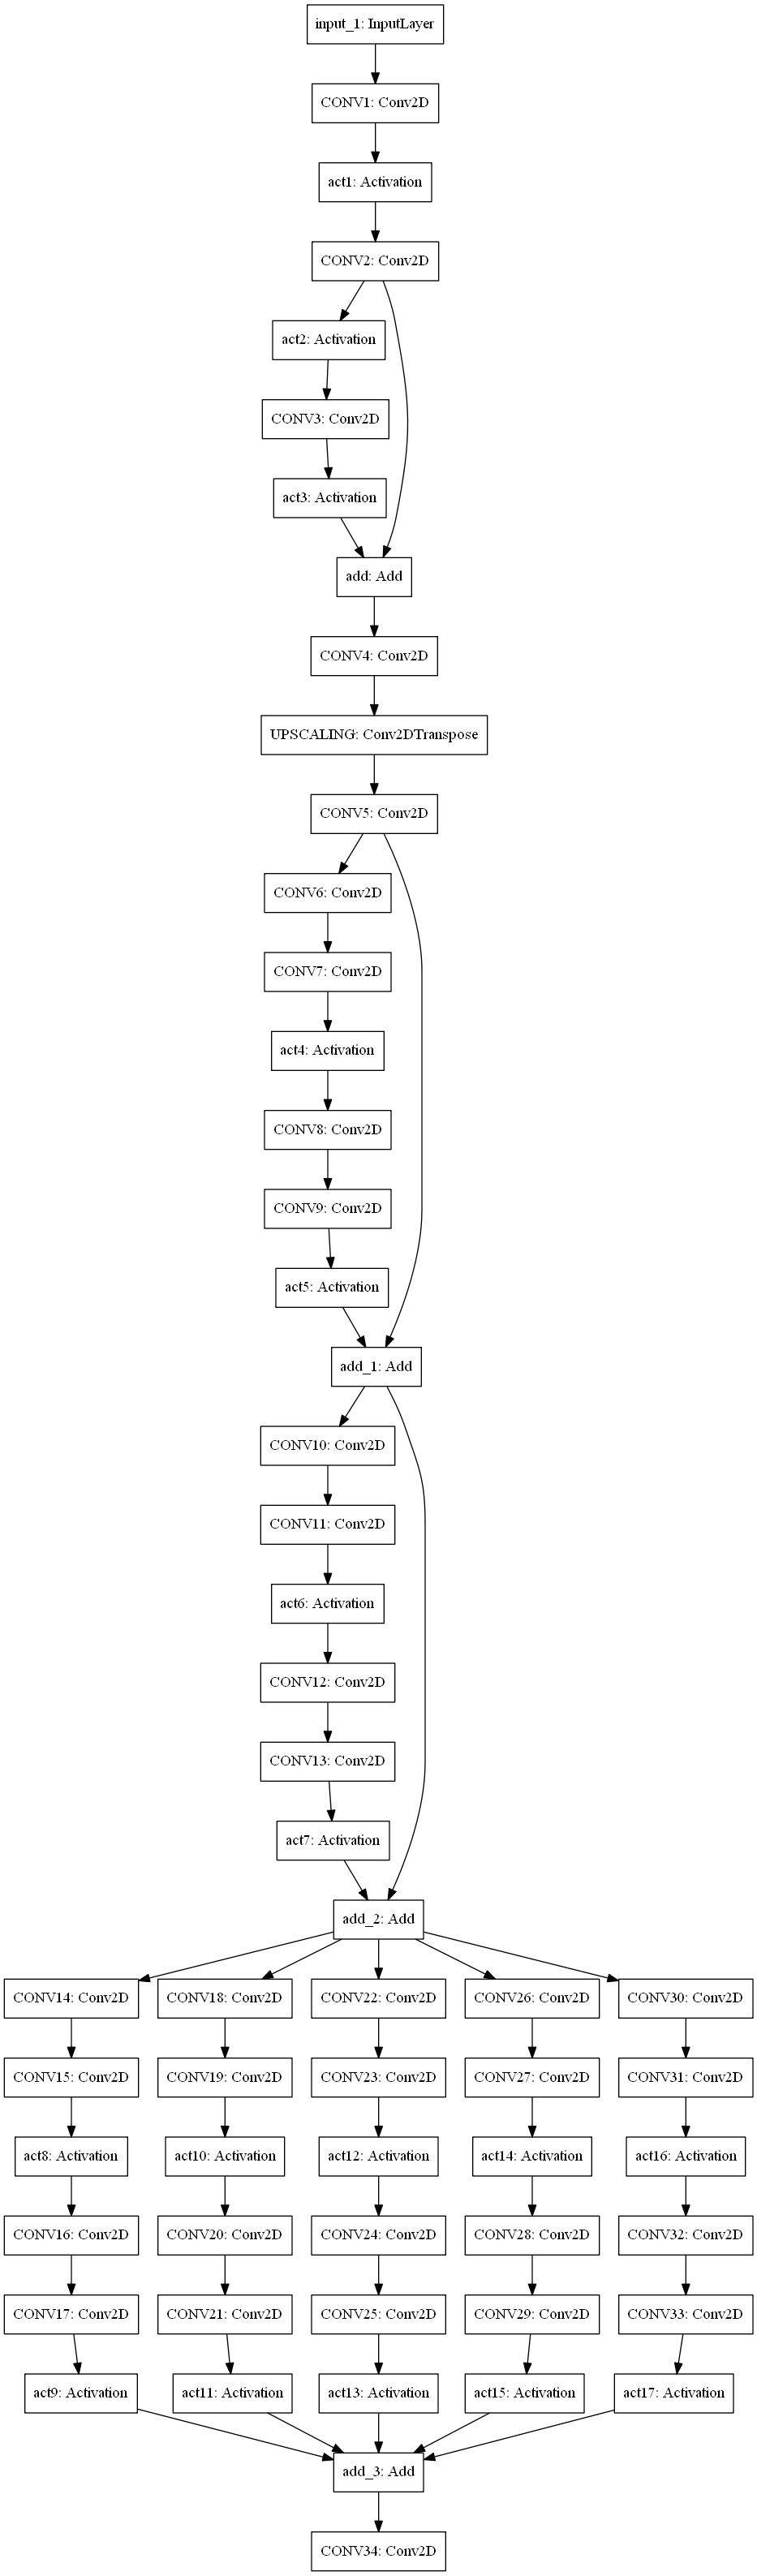

In [23]:
tf.keras.utils.plot_model(model, 'my_first_model.png')

In [24]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD

In [25]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint('best_model_improved.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

In [27]:
history = model.fit(X,labels,batch_size=32,shuffle=True,validation_split=0.01 ,epochs=200,callbacks=[checkpoint],
                    verbose=1 )

Train on 18660 samples, validate on 189 samples
Epoch 1/200
18660/18660 [==============================] - 11s 582us/sample - loss: 8130.7719 - accuracy: 0.7023 - val_loss: 136.4645 - val_accuracy: 0.9998
Epoch 2/200
18660/18660 [==============================] - 6s 327us/sample - loss: 489.5779 - accuracy: 0.7377 - val_loss: 90.3306 - val_accuracy: 0.9999
Epoch 3/200
18660/18660 [==============================] - 6s 328us/sample - loss: 447.5153 - accuracy: 0.7444 - val_loss: 87.7572 - val_accuracy: 0.9999
Epoch 4/200
18660/18660 [==============================] - 6s 323us/sample - loss: 436.4899 - accuracy: 0.7471 - val_loss: 95.7627 - val_accuracy: 0.9999
Epoch 5/200
18660/18660 [==============================] - 6s 323us/sample - loss: 1778.8304 - accuracy: 0.6780 - val_loss: 198.6034 - val_accuracy: 0.9997
Epoch 6/200
18660/18660 [==============================] - 6s 325us/sample - loss: 522.1398 - accuracy: 0.7280 - val_loss: 110.3589 - val_accuracy: 0.9997
Epoch 7/200
18660/1866

18660/18660 [==============================] - 16s 849us/sample - loss: 72.5887 - accuracy: 0.9519 - val_loss: 18.8168 - val_accuracy: 1.0000
Epoch 54/200
18660/18660 [==============================] - 16s 841us/sample - loss: 70.2742 - accuracy: 0.9573 - val_loss: 18.5448 - val_accuracy: 1.0000
Epoch 55/200
18660/18660 [==============================] - 16s 842us/sample - loss: 69.3108 - accuracy: 0.9570 - val_loss: 57.1320 - val_accuracy: 1.0000
Epoch 56/200
18660/18660 [==============================] - 16s 845us/sample - loss: 69.3190 - accuracy: 0.9555 - val_loss: 19.3818 - val_accuracy: 1.0000
Epoch 57/200
18660/18660 [==============================] - 16s 842us/sample - loss: 70.3133 - accuracy: 0.9549 - val_loss: 24.0962 - val_accuracy: 1.0000
Epoch 58/200
18660/18660 [==============================] - 16s 849us/sample - loss: 66.4377 - accuracy: 0.9586 - val_loss: 18.1353 - val_accuracy: 1.0000
Epoch 59/200
18660/18660 [==============================] - 16s 848us/sample - loss

18660/18660 [==============================] - 17s 894us/sample - loss: 55.0627 - accuracy: 0.9627 - val_loss: 16.9997 - val_accuracy: 1.0000
Epoch 106/200
18660/18660 [==============================] - 17s 898us/sample - loss: 56.3089 - accuracy: 0.9579 - val_loss: 18.2757 - val_accuracy: 1.0000
Epoch 107/200
18660/18660 [==============================] - 17s 891us/sample - loss: 55.7551 - accuracy: 0.9601 - val_loss: 26.0291 - val_accuracy: 1.0000
Epoch 108/200
18660/18660 [==============================] - 17s 910us/sample - loss: 57.3941 - accuracy: 0.9571 - val_loss: 16.7170 - val_accuracy: 1.0000
Epoch 109/200
18660/18660 [==============================] - 17s 896us/sample - loss: 54.3304 - accuracy: 0.9627 - val_loss: 39.4480 - val_accuracy: 1.0000
Epoch 110/200
18660/18660 [==============================] - 17s 903us/sample - loss: 55.9203 - accuracy: 0.9597 - val_loss: 17.1619 - val_accuracy: 1.0000
Epoch 111/200
18660/18660 [==============================] - 17s 903us/sample 

Epoch 158/200
18660/18660 [==============================] - 6s 336us/sample - loss: 52.1703 - accuracy: 0.9610 - val_loss: 16.7500 - val_accuracy: 1.0000
Epoch 159/200
18660/18660 [==============================] - 6s 337us/sample - loss: 48.5778 - accuracy: 0.9633 - val_loss: 16.9847 - val_accuracy: 1.0000
Epoch 160/200
18660/18660 [==============================] - 6s 337us/sample - loss: 48.8954 - accuracy: 0.9620 - val_loss: 19.0823 - val_accuracy: 1.0000
Epoch 161/200
18660/18660 [==============================] - 6s 338us/sample - loss: 49.6626 - accuracy: 0.9617 - val_loss: 21.1619 - val_accuracy: 1.0000
Epoch 162/200
18660/18660 [==============================] - 6s 345us/sample - loss: 49.6369 - accuracy: 0.9614 - val_loss: 16.6984 - val_accuracy: 1.0000
Epoch 163/200
18660/18660 [==============================] - 6s 345us/sample - loss: 50.1194 - accuracy: 0.9603 - val_loss: 16.6861 - val_accuracy: 1.0000
Epoch 164/200
18660/18660 [==============================] - 6s 338us/